# Task 2: Image Classification using Deep Neural Networks (iRoads Dataset)

## Overview
This notebook implements image classification on the iRoads dataset using transfer learning with pre-trained ResNet50. The analysis follows the Task 2 specification requirements:

### Key Components:
1. **Preprocessing**: Image resizing and normalization for ResNet50 compatibility
2. **Feature Extraction**: Using pre-trained ResNet50 to extract 2048-dimensional feature vectors
3. **Dimensionality Reduction**: PCA and t-SNE for 2D visualization of the latent feature space
4. **Clustering**: K-Means clustering with quality evaluation (Davies-Bouldin, Silhouette, Calinski-Harabasz)
5. **Classification**: Multiple classifier comparison with comprehensive performance metrics
6. **Evaluation**: Accuracy, Precision, Recall, F1-Score, Confusion Matrix, ROC Curves, Learning Curves

Dataset: iRoads - Road condition images across multiple categories (Daylight, Night, RainyDay, RainyNight, Snowy, SunStroke, Tunnel)

## 1. Import Libraries and Setup

In [17]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torchvision.models import ResNet50_Weights
from PIL import ImageFile

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_curve, auc, roc_auc_score
)
import joblib

ImageFile.LOAD_TRUNCATED_IMAGES = True
RANDOM_SEED = 67

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

## 2. Feature Extraction with ResNet50

We use a pre-trained ResNet50 model to extract features from road images. The final classification layer is removed to obtain 2048-dimensional feature vectors.

In [19]:
# Image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load ResNet50 and remove classification head
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.eval()
feature_extractor.to(device)

def extract_features(batch_images):
    with torch.no_grad():
        batch_images = batch_images.to(device)
        features = feature_extractor(batch_images)
        features = features.reshape(features.size(0), -1)
        return features.cpu().numpy()

# Load dataset
dataset = datasets.ImageFolder("data/roads", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Extract features
all_features = []
all_labels = []

for images, labels in tqdm(loader, desc="Extracting features"):
    features = extract_features(images)
    all_features.append(features)
    all_labels.append(labels.numpy())

X = np.concatenate(all_features, axis=0)
y = np.concatenate(all_labels, axis=0)

print(f"\nFeature shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Classes: {dataset.classes}")

Using device: cuda


Extracting features: 100%|██████████| 146/146 [00:03<00:00, 39.78it/s]


Feature shape: (4656, 2048)
Labels shape: (4656,)
Number of classes: 7
Classes: ['Daylight', 'Night', 'RainyDay', 'RainyNight', 'Snowy', 'SunStroke', 'Tunnel']


## 3. Dataset Analysis

Examine class distribution to ensure balanced representation.

In [20]:
print("\nClass Distribution:")
print("-" * 50)
for i, class_name in enumerate(dataset.classes):
    count = np.sum(y == i)
    percentage = (count / len(y)) * 100
    print(f"{class_name:20s}: {count:4d} samples ({percentage:5.1f}%)")


Class Distribution:
--------------------------------------------------
Daylight            :  903 samples ( 19.4%)
Night               : 1050 samples ( 22.6%)
RainyDay            : 1049 samples ( 22.5%)
RainyNight          :  431 samples (  9.3%)
Snowy               :  569 samples ( 12.2%)
SunStroke           :  347 samples (  7.5%)
Tunnel              :  307 samples (  6.6%)


## 4. Train-Test Split

Use stratified shuffle split to ensure random sampling while maintaining class distribution. This is critical because images may be sequentially ordered.

In [21]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 3724 samples
Test set: 932 samples


## 4. Dimensionality Reduction and Visualization

To understand the feature space structure, we apply dimensionality reduction techniques to visualize the 2048-dimensional features in 2D. We use:
- **PCA (Principal Component Analysis)**: Linear technique preserving global variance
- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: Non-linear technique preserving local structure

PCA explained variance ratio: [0.25041258 0.16551079]
Total variance explained: 0.4159


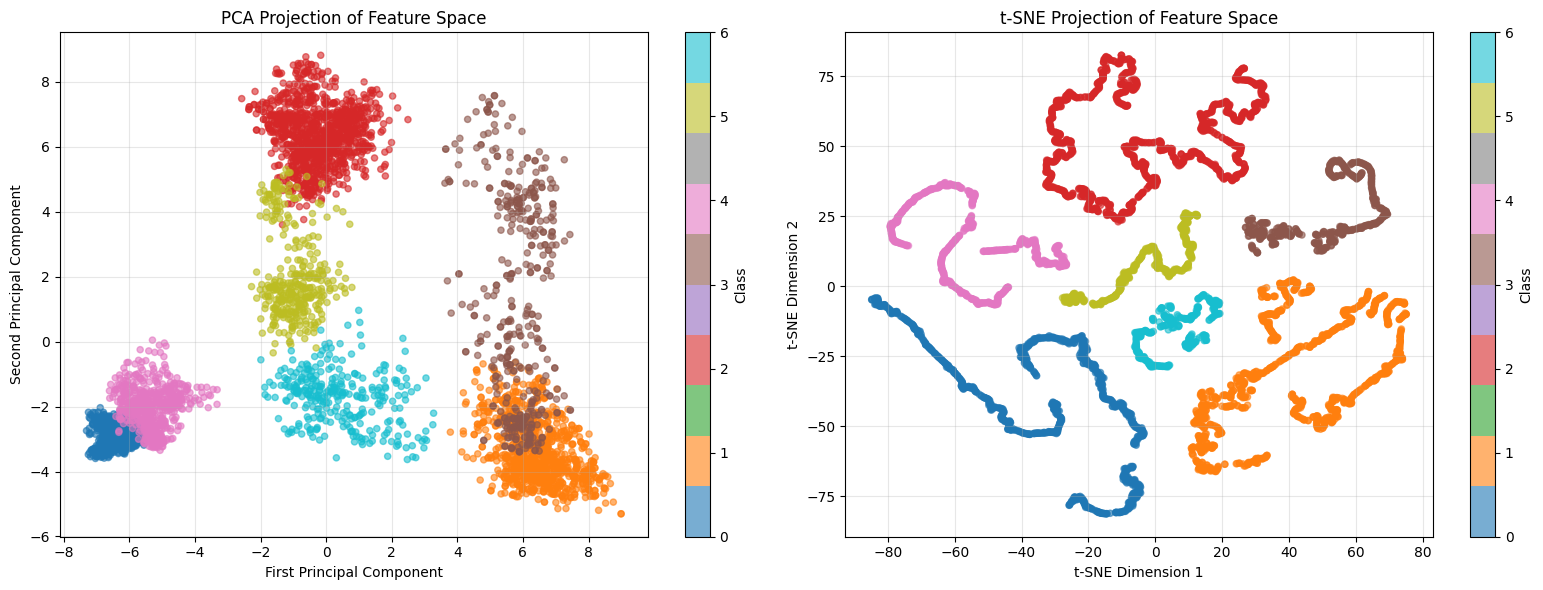


Class labels: ['Daylight', 'Night', 'RainyDay', 'RainyNight', 'Snowy', 'SunStroke', 'Tunnel']


In [22]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Apply t-SNE for non-linear dimensionality reduction
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X)

# Visualize both projections
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA visualization
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6, s=20)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('PCA Projection of Feature Space')
axes[0].grid(alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Class')

# t-SNE visualization
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.6, s=20)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title('t-SNE Projection of Feature Space')
axes[1].grid(alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Class')

plt.tight_layout()
plt.show()

print(f"\nClass labels: {dataset.classes}")

## 5. Clustering in Latent Space

Perform K-Means clustering on the extracted features to discover natural groupings. We evaluate clustering quality using:
- **Davies-Bouldin Index**: Lower values indicate better separation between clusters
- **Silhouette Score**: Ranges from -1 to 1, higher values indicate better-defined clusters
- **Calinski-Harabasz Index**: Higher values indicate dense and well-separated clusters

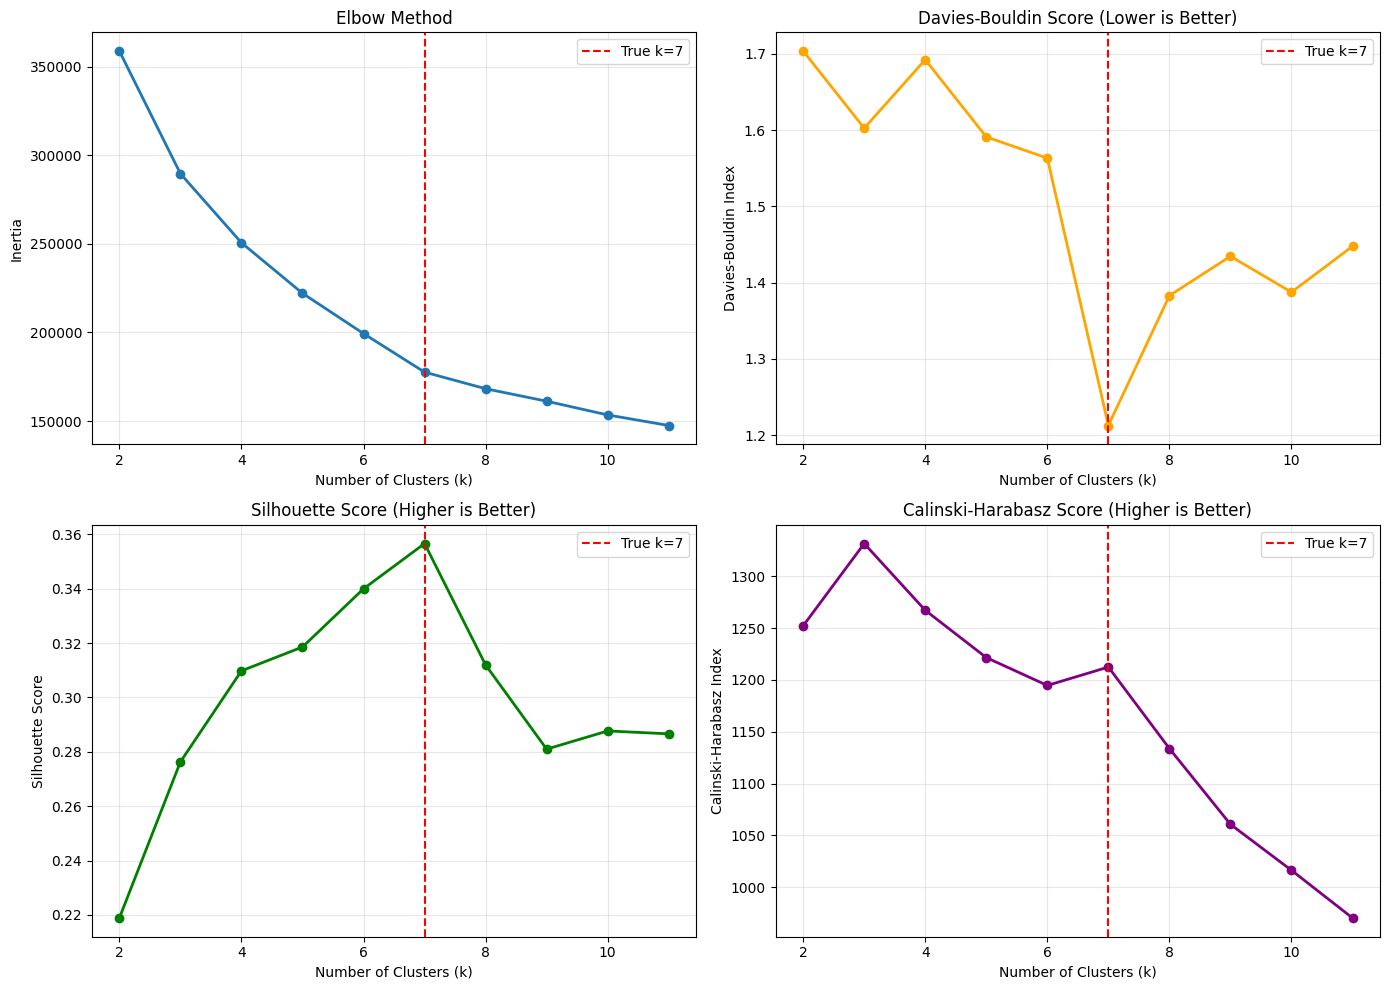


Clustering Quality Metrics:
k     Davies-Bouldin     Silhouette      Calinski-Harabasz   
------------------------------------------------------------
2     1.7037             0.2189          1252.22             
3     1.6026             0.2763          1331.55             
4     1.6924             0.3098          1267.15             
5     1.5912             0.3185          1221.55             
6     1.5633             0.3399          1194.65             
7     1.2127             0.3566          1212.41              *
8     1.3829             0.3119          1133.78             
9     1.4346             0.2810          1060.65             
10    1.3875             0.2877          1016.31             
11    1.4477             0.2866          970.29              

Optimal k based on Silhouette Score: 7
True number of classes: 7


In [23]:
# Determine optimal number of clusters using elbow method and silhouette analysis
n_classes = len(dataset.classes)
k_range = range(2, min(15, len(dataset.classes) + 5))

metrics_data = {
    'k': [],
    'inertia': [],
    'davies_bouldin': [],
    'silhouette': [],
    'calinski_harabasz': []
}

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    metrics_data['k'].append(k)
    metrics_data['inertia'].append(kmeans.inertia_)
    metrics_data['davies_bouldin'].append(davies_bouldin_score(X, cluster_labels))
    metrics_data['silhouette'].append(silhouette_score(X, cluster_labels))
    metrics_data['calinski_harabasz'].append(calinski_harabasz_score(X, cluster_labels))

# Plot clustering metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(metrics_data['k'], metrics_data['inertia'], 'o-', linewidth=2)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axvline(n_classes, color='red', linestyle='--', label=f'True k={n_classes}')
axes[0, 0].legend()

axes[0, 1].plot(metrics_data['k'], metrics_data['davies_bouldin'], 'o-', linewidth=2, color='orange')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].set_title('Davies-Bouldin Score (Lower is Better)')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].axvline(n_classes, color='red', linestyle='--', label=f'True k={n_classes}')
axes[0, 1].legend()

axes[1, 0].plot(metrics_data['k'], metrics_data['silhouette'], 'o-', linewidth=2, color='green')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Silhouette Score')
axes[1, 0].set_title('Silhouette Score (Higher is Better)')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axvline(n_classes, color='red', linestyle='--', label=f'True k={n_classes}')
axes[1, 0].legend()

axes[1, 1].plot(metrics_data['k'], metrics_data['calinski_harabasz'], 'o-', linewidth=2, color='purple')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Calinski-Harabasz Index')
axes[1, 1].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].axvline(n_classes, color='red', linestyle='--', label=f'True k={n_classes}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Optimal k selection based on silhouette score
optimal_k_idx = np.argmax(metrics_data['silhouette'])
optimal_k = metrics_data['k'][optimal_k_idx]

print(f"\nClustering Quality Metrics:")
print(f"{'k':<5} {'Davies-Bouldin':<18} {'Silhouette':<15} {'Calinski-Harabasz':<20}")
print("-" * 60)
for i in range(len(metrics_data['k'])):
    k = metrics_data['k'][i]
    marker = " *" if k == optimal_k else ""
    print(f"{k:<5} {metrics_data['davies_bouldin'][i]:<18.4f} {metrics_data['silhouette'][i]:<15.4f} {metrics_data['calinski_harabasz'][i]:<20.2f}{marker}")

print(f"\nOptimal k based on Silhouette Score: {optimal_k}")
print(f"True number of classes: {n_classes}")

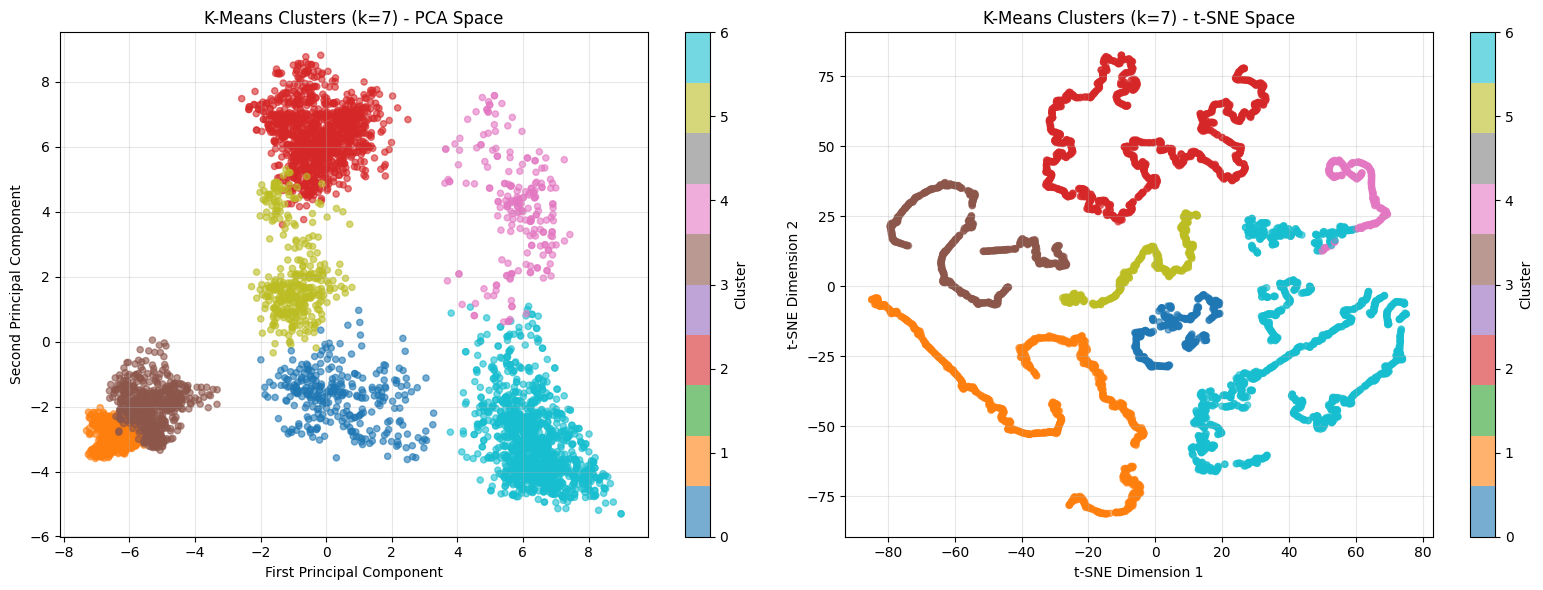


Final Clustering Evaluation (k=7):
Davies-Bouldin Index: 1.2127 (lower is better)
Silhouette Score: 0.3566 (higher is better)
Calinski-Harabasz Index: 1212.41 (higher is better)


In [24]:
# Perform final clustering with true number of classes
kmeans_final = KMeans(n_clusters=n_classes, random_state=RANDOM_SEED, n_init=10)
cluster_labels = kmeans_final.fit_predict(X)

# Visualize clusters in reduced dimensions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Clusters on PCA
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6, s=20)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title(f'K-Means Clusters (k={n_classes}) - PCA Space')
axes[0].grid(alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster')

# Clusters on t-SNE
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6, s=20)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title(f'K-Means Clusters (k={n_classes}) - t-SNE Space')
axes[1].grid(alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Cluster')

plt.tight_layout()
plt.show()

# Evaluate clustering quality
db_score = davies_bouldin_score(X, cluster_labels)
sil_score = silhouette_score(X, cluster_labels)
ch_score = calinski_harabasz_score(X, cluster_labels)

print(f"\nFinal Clustering Evaluation (k={n_classes}):")
print(f"Davies-Bouldin Index: {db_score:.4f} (lower is better)")
print(f"Silhouette Score: {sil_score:.4f} (higher is better)")
print(f"Calinski-Harabasz Index: {ch_score:.2f} (higher is better)")

## 5. Classifier Definition

Define multiple classifiers to compare performance. StandardScaler is applied to distance-based and linear models.

In [25]:
classifiers = {
    'Logistic Regression': make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=2000, solver="lbfgs", random_state=RANDOM_SEED, n_jobs=-1)
    ),
    'KNN (k=5)': make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    ),
    'SVM (Linear)': make_pipeline(
        StandardScaler(),
        SVC(kernel='linear', probability=True, random_state=RANDOM_SEED)
    ),
    'Decision Tree': DecisionTreeClassifier(max_depth=20, random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=20, random_state=RANDOM_SEED, n_jobs=-1
    )
}

print(f"Defined {len(classifiers)} classifiers for evaluation")

Defined 5 classifiers for evaluation


## 6. Cross-Validation Training

Train each classifier using 5-fold stratified cross-validation to estimate generalization performance.

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
results = {}

for clf_name, clf in tqdm(classifiers.items(), desc="Training classifiers"):
    fold_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        clf.fit(X_fold_train, y_fold_train)
        y_pred = clf.predict(X_fold_val)
        fold_scores.append(accuracy_score(y_fold_val, y_pred))
    
    results[clf_name] = {
        'model': clf,
        'cv_accuracy': np.mean(fold_scores),
        'cv_std': np.std(fold_scores),
        'fold_scores': fold_scores
    }

print("\nCross-Validation Results:")
print("-" * 60)
for clf_name, result in sorted(results.items(), key=lambda x: x[1]['cv_accuracy'], reverse=True):
    print(f"{clf_name:20s}: {result['cv_accuracy']:.4f} ± {result['cv_std']:.4f}")

Training classifiers: 100%|██████████| 5/5 [00:35<00:00,  7.04s/it]


Cross-Validation Results:
------------------------------------------------------------
Logistic Regression : 1.0000 ± 0.0000
SVM (Linear)        : 1.0000 ± 0.0000
Random Forest       : 1.0000 ± 0.0000
KNN (k=5)           : 0.9995 ± 0.0007
Decision Tree       : 0.9914 ± 0.0040


## 7. Final Model Evaluation

Select best classifier, retrain on full training set, and evaluate on test set.

In [27]:
# Retrain all models on full training set
for clf_name, result in results.items():
    clf = result['model']
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    result['test_accuracy'] = accuracy_score(y_test, y_pred)
    result['predictions'] = y_pred

# Select best classifier
best_clf_name = max(results.keys(), key=lambda x: results[x]['cv_accuracy'])
best_clf = results[best_clf_name]['model']
best_predictions = results[best_clf_name]['predictions']

print(f"\nBest Classifier: {best_clf_name}")
print(f"CV Accuracy: {results[best_clf_name]['cv_accuracy']:.4f}")
print(f"Test Accuracy: {results[best_clf_name]['test_accuracy']:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=dataset.classes))

# Save best model
joblib.dump(best_clf, "roads_classifier.joblib")
print("\nModel saved to: roads_classifier.joblib")


Best Classifier: Logistic Regression
CV Accuracy: 1.0000
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    Daylight       1.00      1.00      1.00       181
       Night       1.00      1.00      1.00       210
    RainyDay       1.00      1.00      1.00       210
  RainyNight       1.00      1.00      1.00        86
       Snowy       1.00      1.00      1.00       114
   SunStroke       1.00      1.00      1.00        70
      Tunnel       1.00      1.00      1.00        61

    accuracy                           1.00       932
   macro avg       1.00      1.00      1.00       932
weighted avg       1.00      1.00      1.00       932


Model saved to: roads_classifier.joblib


In [28]:
# Create comprehensive performance comparison table
print("\nDetailed Performance Metrics for All Classifiers:")
print("=" * 100)
print(f"{'Classifier':<25} {'CV Acc':<12} {'Test Acc':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 100)

for clf_name in sorted(results.keys(), key=lambda x: results[x]['test_accuracy'], reverse=True):
    result = results[clf_name]
    y_pred = result['predictions']
    
    # Calculate macro-averaged metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    
    print(f"{clf_name:<25} {result['cv_accuracy']:<12.4f} {result['test_accuracy']:<12.4f} "
          f"{precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")

print("=" * 100)
print("\nNote: All metrics are macro-averaged across all classes")


Detailed Performance Metrics for All Classifiers:
Classifier                CV Acc       Test Acc     Precision    Recall       F1-Score    
----------------------------------------------------------------------------------------------------
Logistic Regression       1.0000       1.0000       1.0000       1.0000       1.0000      
SVM (Linear)              1.0000       1.0000       1.0000       1.0000       1.0000      
Random Forest             1.0000       1.0000       1.0000       1.0000       1.0000      
KNN (k=5)                 0.9995       0.9989       0.9993       0.9977       0.9985      
Decision Tree             0.9914       0.9946       0.9943       0.9945       0.9944      

Note: All metrics are macro-averaged across all classes


## 8. Confusion Matrix Visualization

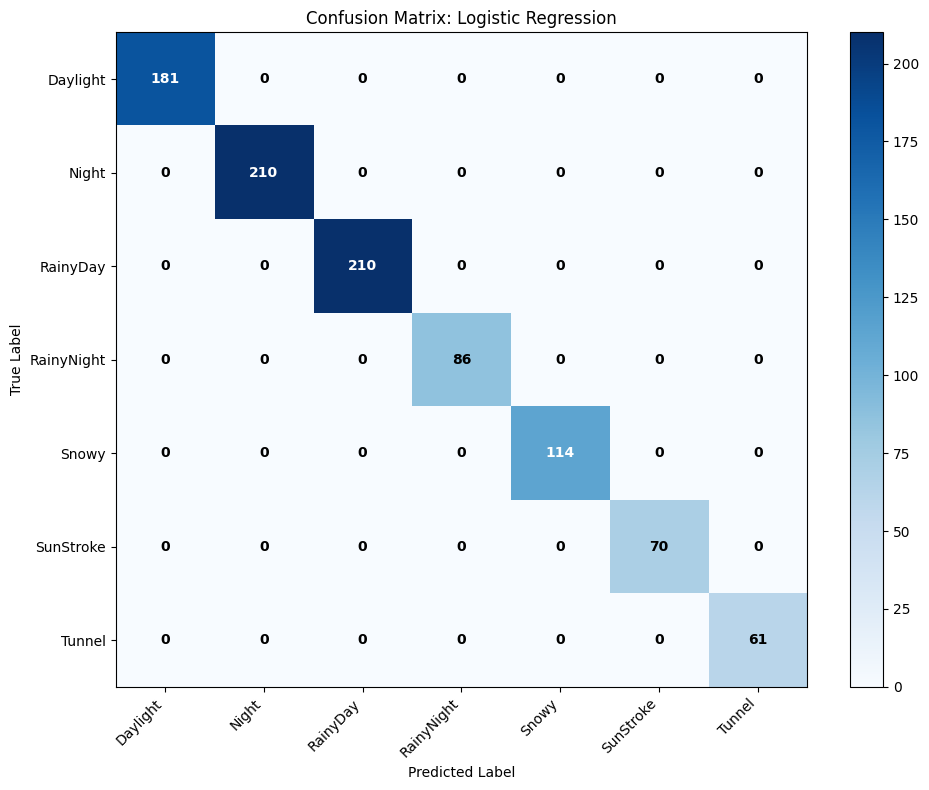

In [29]:
cm = confusion_matrix(y_test, best_predictions)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap='Blues', aspect='auto')

ax.set_xticks(range(len(dataset.classes)))
ax.set_yticks(range(len(dataset.classes)))
ax.set_xticklabels(dataset.classes, rotation=45, ha='right')
ax.set_yticklabels(dataset.classes)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'Confusion Matrix: {best_clf_name}')

for i in range(len(dataset.classes)):
    for j in range(len(dataset.classes)):
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax.text(j, i, cm[i, j], ha="center", va="center", color=color, fontweight='bold')

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## 9. ROC Curve Analysis (Multi-class)

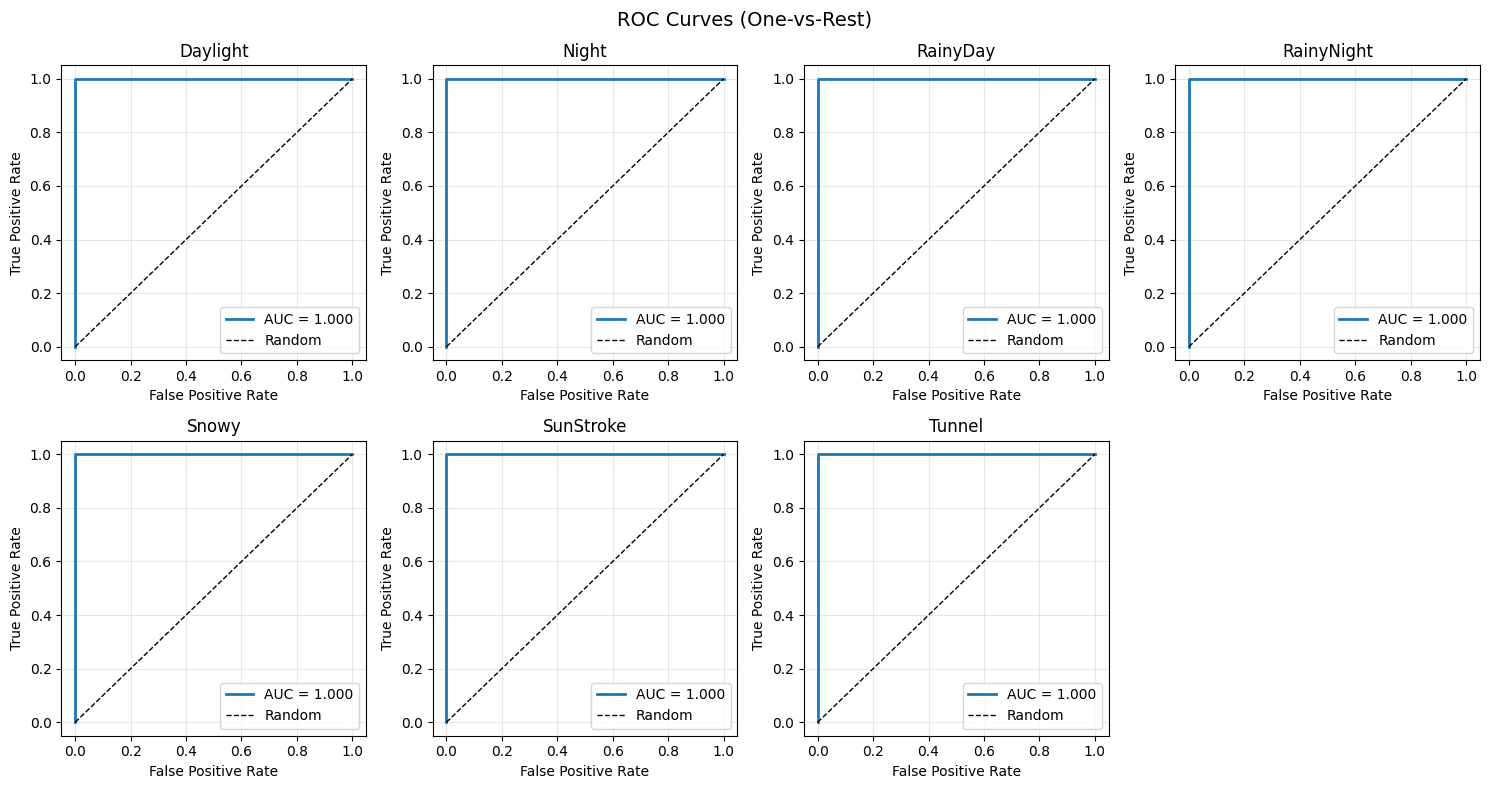


Macro-average ROC AUC: 1.0000


In [30]:
y_test_bin = label_binarize(y_test, classes=range(len(dataset.classes)))
y_pred_proba = best_clf.predict_proba(X_test)

n_classes = len(dataset.classes)
fig, axes = plt.subplots(2, (n_classes + 1) // 2, figsize=(15, 8))
axes = axes.flatten()

for i, class_name in enumerate(dataset.classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    axes[i].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
    axes[i].plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'{class_name}')
    axes[i].legend(loc="lower right")
    axes[i].grid(alpha=0.3)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('ROC Curves (One-vs-Rest)', fontsize=14)
plt.tight_layout()
plt.show()

macro_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='macro')
print(f"\nMacro-average ROC AUC: {macro_auc:.4f}")

## 10. Learning Curves

Assess whether the model would benefit from more training data or if overfitting is occurring.

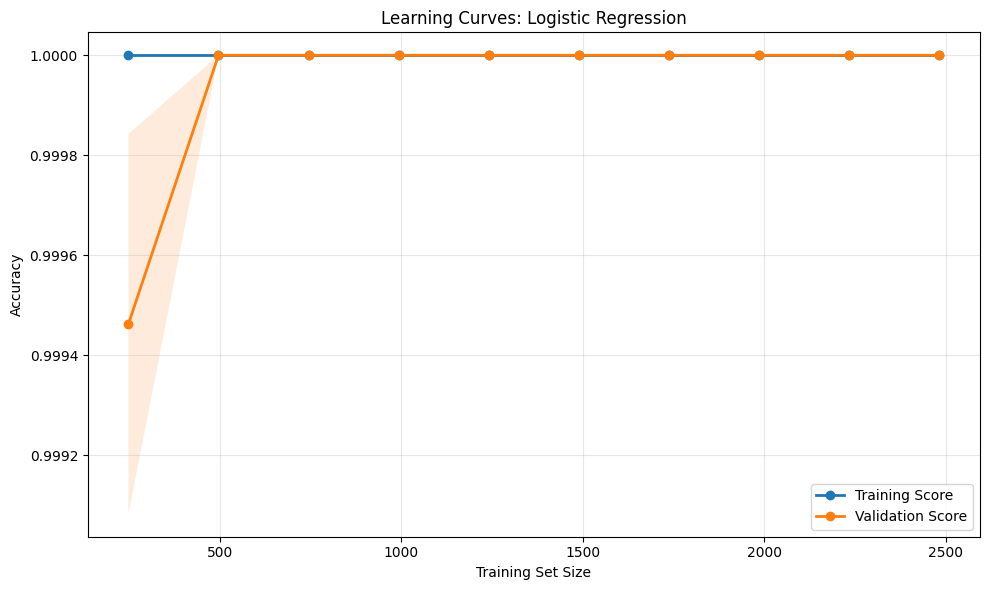


Final Training Score: 1.0000
Final Validation Score: 1.0000
Train-Validation Gap: 0.0000
Good generalization achieved


In [31]:
train_sizes, train_scores, val_scores = learning_curve(
    best_clf, X_train, y_train,
    cv=3, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.plot(train_sizes, val_mean, 'o-', label='Validation Score', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15)

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title(f'Learning Curves: {best_clf_name}')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

gap = train_mean[-1] - val_mean[-1]
print(f"\nFinal Training Score: {train_mean[-1]:.4f}")
print(f"Final Validation Score: {val_mean[-1]:.4f}")
print(f"Train-Validation Gap: {gap:.4f}")

if gap > 0.1:
    print("Warning: High overfitting detected")
elif gap > 0.05:
    print("Note: Moderate overfitting")
else:
    print("Good generalization achieved")

## 11. Summary

### Key Findings:
- Best performing classifier identified through cross-validation
- Model generalization assessed using learning curves
- Per-class performance evaluated with confusion matrix and ROC curves
- Final model saved for deployment